In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress,t,tstd,tmean

In [26]:
filepath  = '/Users/andreaithompson/Documents/ResearchBMR/MojdehTests/YoungModulus/AllData/Anode_No_oxalic_C_40samples'
excelPath = '/Users/andreaithompson/Documents/ResearchBMR/MojdehTests/YoungModulus/AllData/zNewExcels/Anode_No_oxalic_C_40samples.xlsx'
graphPath = '/Users/andreaithompson/Documents/ResearchBMR/MojdehTests/YoungModulus/AllData/zNewGraphs/Graphs'


In [3]:
stack_height = 1.942 #mm
area = 11*11 #mm^2 
fileNames = os.listdir(filepath)
#fileNames.remove('.DS_Store')
numFiles = len(fileNames)
print(fileNames)

['Anode_No_oxalic_C_40samples_4_1.csv', 'Anode_No_oxalic_C_40samples_2_1.csv', 'Anode_No_oxalic_C_40samples_3_1.csv', 'Anode_No_oxalic_C_40samples_1_1.csv']


In [43]:
peakpoint = np.zeros(numFiles)
bounds = np.zeros((numFiles,2))
graphRanges = np.array([[0.00,0.001],[0.00,0.01],[0.01,4.5]]) #kN
numRanges = len(graphRanges)
lYM = np.zeros((numRanges,numFiles))
lr = np.zeros((numRanges,numFiles))
cYM = np.zeros((numRanges,numFiles))
cr = np.zeros((numRanges,numFiles))
statYMl = np.zeros((numRanges,2))
statYMc = np.zeros((numRanges,2))

In [44]:
'''determine where the peak of the force/displace curve '''
def peak(i,p):
    #print(i,p)
    data = pd.read_csv(filepath +'/'+ fileNames[i])
    raw_data = np.zeros((2,len(data)-1))
    for j in range(len(data)-1):
        raw_data[0][j] = float(data["Displacement"][j+1]) 
        raw_data[1][j] = float(data["Force"][j+1])  
    s = 0
    if p == 0:
        s = 0.0009
    if p == 1:
        s = 0.009
    if p == 2:
        s = 4.5
    #print(s)
    for j in range(len(raw_data[1])):
        if raw_data[1][j] > s:
            s = j
            #print(s,'1')
    return s

In [30]:
def dis(i):
    data = pd.read_csv(filepath +'/'+ fileNames[i])
    raw_data = np.zeros((2,len(data)-1))
    for j in range(len(data)-1):
        raw_data[0][j] = float(data["Displacement"][j+1]) 
        raw_data[1][j] = float(data["Force"][j+1])    
    q = 0 
    for j in range(len(data)-1):
        if raw_data[1][j] == 0.0001:
            q = np.append(q,j)
    #print(q[1],raw_data[0][q[1]])
    '''for j in range(len(q)-1):
        print(raw_data[0][q[j]],raw_data[1][q[j]])'''
    return raw_data[0][q[1]]

In [31]:
dis(0)

4.1367

In [32]:
'''filters unwanted region of the force/displacement curve'''
def curve(i,bottom,top):
    data = pd.read_csv(filepath +'/'+ fileNames[i])
    #print(len(data))
    raw_data = np.zeros((2,len(data)-1))
    for j in range(len(data)-1):
        raw_data[0][j] = float(data["Displacement"][j+1]) 
        raw_data[1][j] = float(data["Force"][j+1])  
    s = int(peakpoint[i])
    #print(s)
    p_data = np.zeros((2,s))
    for j in range(s):
        p_data[0][j] = raw_data[0][j]
        p_data[1][j] = raw_data[1][j]
    o = 0 
    for j in range(len(p_data[1])-1):
        if p_data[1][j] > bottom:
            #print(p_data[1][j])
            o = np.append(o,j)
    #e = (o[len(o)-1]-o[1])
    e = o[1]
    h = 0
    for j in range(len(p_data[1])-1):
        if p_data[1][j] < top:
            h = np.append(h,j)  
    d = h[len(h)-1]
    return [e,d]

In [33]:
'''calculates the stress and the strain'''

def ss(i,dd):
    t,b = dd
    t = int(t)
    b = int(b)
    d = b - t
    data = pd.read_csv(filepath +'/'+ fileNames[i])
    raw_data = np.zeros((2,len(data)-1))
    for j in range(len(data)-1):
        raw_data[0][j] = float(data["Displacement"][j+1]) 
        raw_data[1][j] = float(data["Force"][j+1])  
        
    q = dis(i)
    p_ss = np.zeros((2,d))
    for j in range(d):
        p_ss[0][j] = (raw_data[0][j + t]-q)/stack_height #strain          
        p_ss[1][j] = raw_data[1][j + t]/area #stress 
    return p_ss

In [34]:
def idk(i):
    pss = ss(i,bounds[i])
    #print(fileNames[i])
    t = 0
    for j in range(len(pss[0])):
        #if pss[1][j] > 0.0000099 and pss[1][j] < 0.000011:
        #if pss[1][j] > 0.0000015 and pss[1][j] < 0.0000025: used for uncalender
        if pss[1][j] > 0.0000065 and pss[1][j] < 0.0000075: #used for calender
            t = np.append(t,pss[0][j])
            #print(pss[1][j],pss[0][j])
    #print(t)
    new_t = np.delete(t,0)
    #print(new_t)
    vv = tmean(new_t)
    #print(vv)
    return vv

In [35]:
'''try curvefitting '''
def polyfit(i):
    x,y = ss(i,bounds[i])
    h, res, _, _, _ = np.polyfit(x,y,6,full=True)
    return h,res
    #print(h)
    #print(res)
def func(x,a,b,c,d,e,f,g):
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g
    
def der(x,a,b,c,d,e,f):
    return a*6*x**5 + b*5*x**4 + c*4*x**3 + d*3*x**2 + e*2*x + f


In [36]:
'''function that calculates YM and gives the r value'''

def ym(i):
    z = linregress(ss(i,bounds[i]))
    return [z[0],z[2]]

In [37]:
'''function that graphs the region which the YM is being calculated for. 
 This function also saves the graph '''

def graphs(i,j):
    a = str(j+1)
    a = "bound" + a
    z = linregress(ss(i,bounds[i]))
    #print(polyfit(i))
    h = polyfit(i)[0]
    vvv = idk(i)
    res = polyfit(i)[1]
    #print(res)
    dvvv = der(vvv,h[0], h[1], h[2], h[3], h[4], h[5])
    #print(der(vvv,h[0], h[1], h[2], h[3], h[4], h[5]))
    plt.figure(figsize=(7, 5)) 
    plt.title(fileNames[i]+a)
    plt.plot(ss(i,bounds[i])[0],func(ss(i,bounds[i])[0],h[0], h[1], h[2], h[3], h[4], h[5], h[6]),'lightcoral',linewidth=5, label = 'CurveFit')
    plt.plot(ss(i,bounds[i])[0],z[0]*ss(i,bounds[i])[0]+z[1],'royalblue',linewidth=2,label='LinearFit')
    plt.plot(ss(i,bounds[i])[0],ss(i,bounds[i])[1],'k.',label='Experimental Data',markersize=3) #,alpha=0.5)
    plt.plot(vvv, 0.000007,'y.',label='SlopeDot',markersize=15)
    #plt.plot(vvv, 0.000002,'y.',label='SlopeDot',markersize=15)
    plt.xlabel('Strain')
    plt.ylabel('Stress')
    plt.figtext(0.15,0.0,"Curve fit Young's Modulus = " + str(round(dvvv,6)) +" GPa, " + "residuals = " + str(round(res[0],12)))
    plt.figtext(0.15,-0.05,"Linear fit Young's Modulus = " + str(round(z[0],6)) +" GPa, " + "r = " + str(round(z[2],5)))
    plt.legend(loc="best") #bbox_to_anchor=(1.04,1)
    plt.savefig(graphPath + "_" + fileNames[i] + a + '1.pdf', bbox_inches = "tight")
    #plt.savefig('/Users/andreaithompson/Documents/ResearchBMR/MojdehTests/YoungModulus/graph' + str(i) + '.pdf', bbox_inches = "tight")
    #plt.close()
    return i,dvvv,res

In [38]:
'''function that calculates the average Young's Modulus with 95% Confidence Interval from all files'''

def stat(*args):
    k = args
    tt = t.ppf(0.95,numFiles-1)
    σ = tstd(k)
    μ = tmean(k)
    cl = tt*σ/numFiles**0.5
    #print(μ(average), "+/-", cl)
    return [μ, cl]

In [39]:
for j in range(numRanges):
    temp_a = graphRanges[j][0]
    temp_b = graphRanges[j][1]
    #print(j)
    for i in range(numFiles):
        peakpoint[i] = peak(i,j)
        #print(temp_a,temp_b)
        bounds[i] = curve(i,temp_a,temp_b)
        idk(i)
        #graphs(i,j)
        '''YM[j][i] = ym(i)[0]
        r[j][i] = ym(i)[1]
    statYM[j] = stat(YM[j])'''

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean o

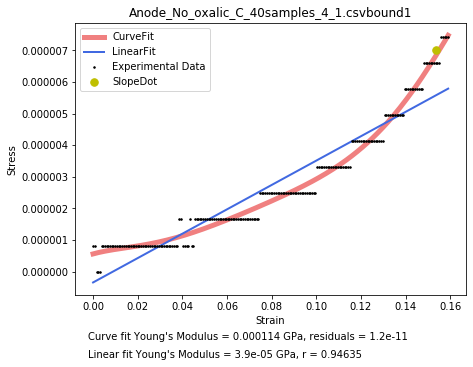

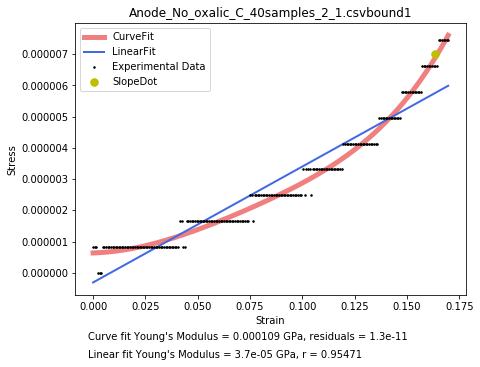

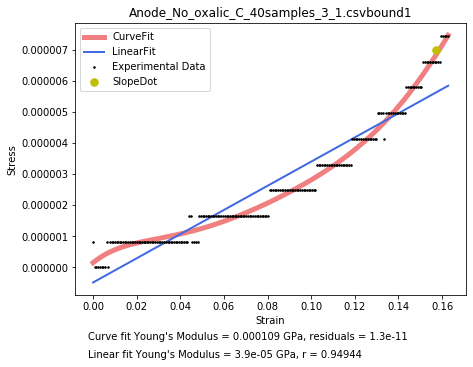

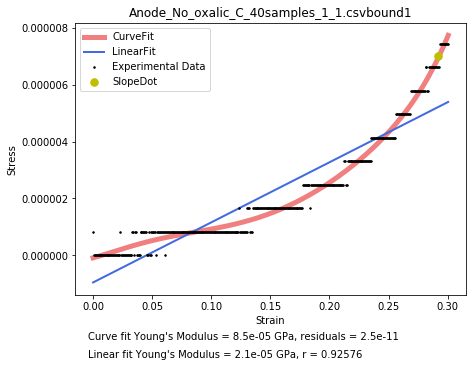

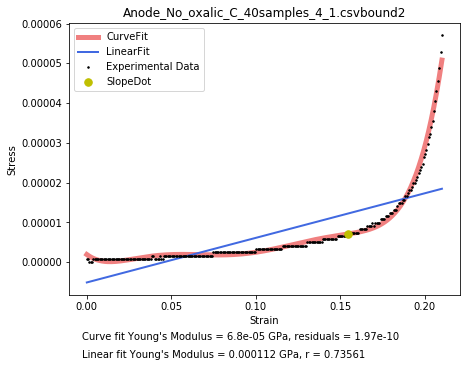

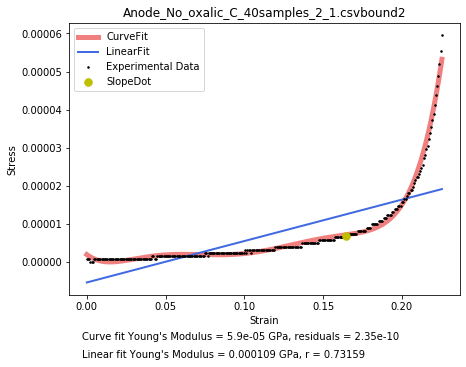

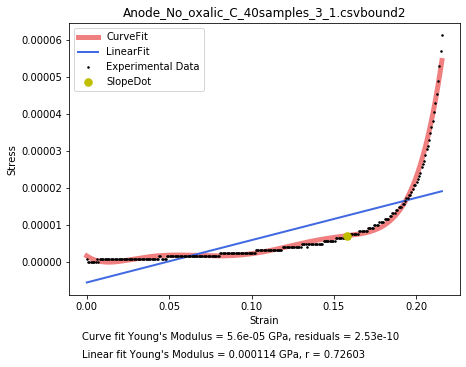

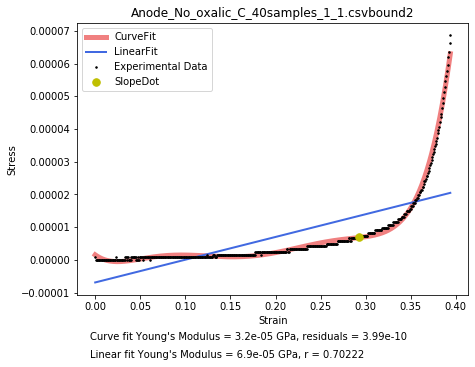

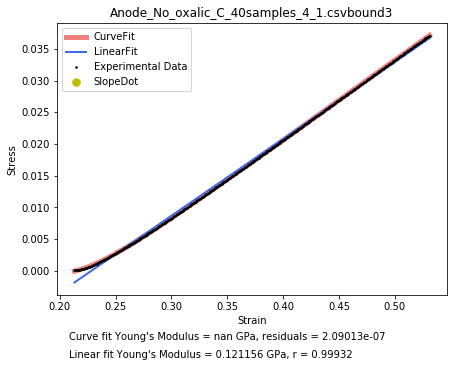

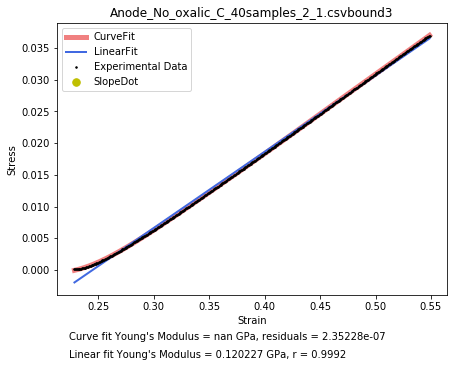

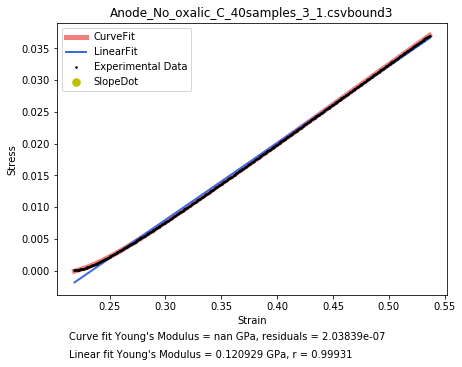

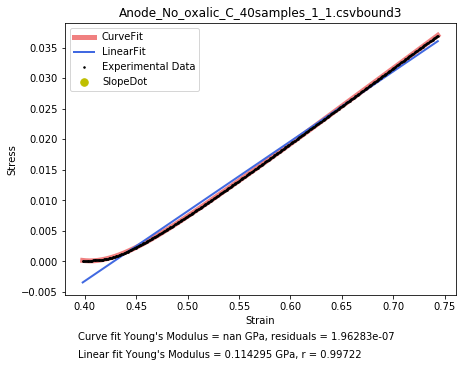

In [45]:
'''applies functions to solve YM for different regions of the stress/strain curve
print graphs of the YM fitting the different regions of the stress/strain curve
takes about 20 secs to run currently'''

for j in range(numRanges):
    temp_a = graphRanges[j][0]
    temp_b = graphRanges[j][1]
    for i in range(numFiles):
        peakpoint[i] = peak(i,j)
        bounds[i] = curve(i,temp_a,temp_b)
        a = graphs(i,j)
        lYM[j][i] = ym(i)[0]
        lr[j][i] = ym(i)[1]
        cYM[j][i] = a[1]
        lr[j][i] = a[2]
    statYMl[j] = stat(lYM[j])
    statYMc[j] = stat(cYM[j])

In [46]:
'''Saves results in an excel file'''

fileNames = np.append(fileNames,' ')
fileNames = np.append(fileNames,'Average YM')
fileNames = np.append(fileNames,'95% CI')

writer = pd.ExcelWriter(excelPath)
workbook = writer.book
df  = pd.DataFrame(fileNames)
df2 = pd.DataFrame(cYM)
df3 = pd.DataFrame(cr)
df4 = pd.DataFrame(statYMc)

headerYM = ['YM1','YM2','YM3']
headerr = ['residuals1','residuals2','residuals3']

writer.sheets["Data"] = workbook.add_worksheet("Data")

df2 = df2.transpose()
df3 = df3.transpose()
df4 = df4.transpose()

df.to_excel(writer, sheet_name = "Data", index = False, header = ["File"], startcol = 0)  #saves the file names 
df2.to_excel(writer, sheet_name = "Data", index = False, header = headerYM, startcol = 1) 
df3.to_excel(writer, sheet_name = "Data", index = False, header = headerr, startcol = 4)
df4.to_excel(writer, sheet_name = "Data", index = False, header = False, startrow = (numFiles+2), startcol = 1)

writer.save()
